In [422]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
import pickle
from openai import AzureOpenAI
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# DBT imports
from evaluation.skill_presence_evaluation import DBTSkills

In [224]:
client = AzureOpenAI(
    api_key = '4d7a2b282805420eb5886248fc82878a',
    api_version = '2023-05-15',
    azure_endpoint = 'https://dbt-openai-eaus.openai.azure.com/'
)

client2 = AzureOpenAI(
    api_key = '12858f5908ee4b17b986977b35d604dd',
    api_version = '2023-05-15',
    azure_endpoint = 'https://dbt-openai-usea2-assistants.openai.azure.com/'
)

In [3]:
with open('./data/Evaluation Prompts.tsv') as f:
    adherence_df = pd.read_csv(f, delimiter='\t')
adherence_df

,Standard,System Prompt,Standard ID,Category,Required in Session
0,Organize by Targets,You are tasked with evaluating a therapist's a...,1,Structural,Y
1,Emotion Focus,You are tasked with evaluating a therapist's a...,2,Structural,Y
2,Describe Specifically,You are tasked with evaluating a therapist's a...,3,Problem Assessment,Y
3,Chain Analysis,You are tasked with assessing a therapist's ad...,4,Problem Assessment,N
4,Teach New Information,You are tasked with evaluating a therapist's a...,5,Problem Solving,N
5,Generate Solutions,You are tasked with evaluating a therapist's a...,6,Problem Solving,Y
6,Activate New Behavior,You are tasked with evaluating a therapist's a...,7,Problem Solving,Y
7,Provide Coaching Feedback,You are tasked with evaluating a therapist's a...,8,Problem Solving,N
8,Generalize New Learning,You are tasked with evaluating a therapist's a...,9,Problem Solving,Y
9,Commitment and Troubleshooting,You are tasked with evaluating a therapist's a...,10,Problem Solving,N


In [16]:
txt = adherence_df['System Prompt'].iloc[0]
txt

'You are tasked with evaluating a therapist\'s adherence to the ORGANIZE BY TARGETS standard within Dialectical Behavior Therapy (DBT). The essence of this standard is that the therapist structures the session time in accordance with the target hierarchy for the client\'s stage of treatment. Carefully analyze the provided conversation log between the therapist and their client, then assign a numerical adherence rating for the therapist based on the following criteria.  Assign a "1" for adherence if: - The therapist structures the session time to appropriately prioritize and address the client\'s immediate needs and goals according to their current stage in treatment.  - The therapist allocates time efficiently to focus on the client\'s most relevant targets, reflecting an understanding of the target hierarchy within DBT. - The therapist demonstrates flexibility in adjusting the session structure to the client\'s evolving treatment needs, ensuring that the therapy remains focused and pr

In [26]:
txt_emb = client.embeddings.create(input=txt, model='text-embedding-3-small').data[0].embedding
txt_emb = np.array(txt_emb)
txt_emb

array([-0.00564414,  0.0476677 ,  0.05504744, ..., -0.00563389,
       -0.02118261,  0.00349342])

In [130]:
adherence_embs = np.zeros(shape=(len(adherence_df), 1536))
adherence_embs
for i, row in adherence_df.iterrows():
    txt = row['System Prompt']
    txt_emb = client.embeddings.create(input=txt, model='text-embedding-3-small').data[0].embedding
    adherence_embs[i,:] = np.array(txt_emb)
adherence_embs

array([[-0.00564372,  0.04766414,  0.05507067, ..., -0.00564372,
        -0.02118103,  0.00349316],
       [ 0.00186826,  0.0431979 ,  0.04077632, ..., -0.01662559,
        -0.01064975,  0.00345987],
       [-0.00248886,  0.04748952,  0.03996172, ..., -0.0087801 ,
        -0.02462627,  0.01340453],
       ...,
       [ 0.0136214 ,  0.04984679,  0.03216984, ..., -0.01873372,
        -0.01976305,  0.0088522 ],
       [-0.00229505,  0.02580676,  0.01304451, ...,  0.0008409 ,
        -0.02871002,  0.01439533],
       [ 0.00048844,  0.04095173,  0.05246415, ...,  0.00877437,
        -0.04047554,  0.01759076]])

<Axes: ylabel='Density'>

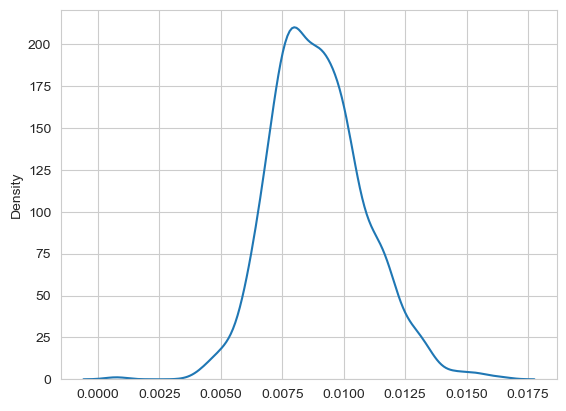

In [218]:
sns.kdeplot(np.std(adherence_embs, axis=0))

In [558]:
umapper = UMAP(
    n_neighbors=7,
    n_components=2,
    min_dist=2.0,
    spread=2.0,
    n_epochs=3000,
    # densmap=True,
)
adherence_embs_umap = umapper.fit_transform(adherence_embs)
means = np.mean(adherence_embs_umap, axis=0)
adherence_embs_umap[:,0] -= means[0]
adherence_embs_umap[:,1] -= means[1]
adherence_embs_umap_ranges = np.ptp(adherence_embs_umap, axis=0)
if adherence_embs_umap_ranges[0] < adherence_embs_umap_ranges[1]:
    adherence_embs_umap[:,[0,1]] = adherence_embs_umap[:,[1,0]]
adherence_embs_umap

C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\umap\umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


array([[ 3.7619019 , -2.0325966 ],
       [-3.6372108 , -1.202383  ],
       [ 0.6203613 ,  2.9351559 ],
       [ 4.9151115 , -3.6680145 ],
       [ 1.6901627 ,  5.84165   ],
       [ 5.643223  ,  2.642105  ],
       [ 2.7427864 ,  2.1248722 ],
       [-1.1293106 ,  5.2818966 ],
       [ 3.9203796 ,  4.6661873 ],
       [ 5.8667526 , -0.5710144 ],
       [-2.1223946 ,  2.912321  ],
       [ 0.5784416 ,  0.4782753 ],
       [-1.4395065 , -0.48838806],
       [ 1.9320412 , -4.6185436 ],
       [-6.1433964 , -3.67198   ],
       [-3.7667503 , -4.001169  ],
       [-5.9553604 , -0.7965107 ],
       [-4.3765297 ,  2.1768055 ],
       [ 1.3577728 , -1.8578892 ],
       [-6.754198  ,  1.612812  ],
       [-0.7760925 , -2.7509842 ],
       [-0.75105286, -5.394066  ],
       [ 3.822853  ,  0.38145828]], dtype=float32)

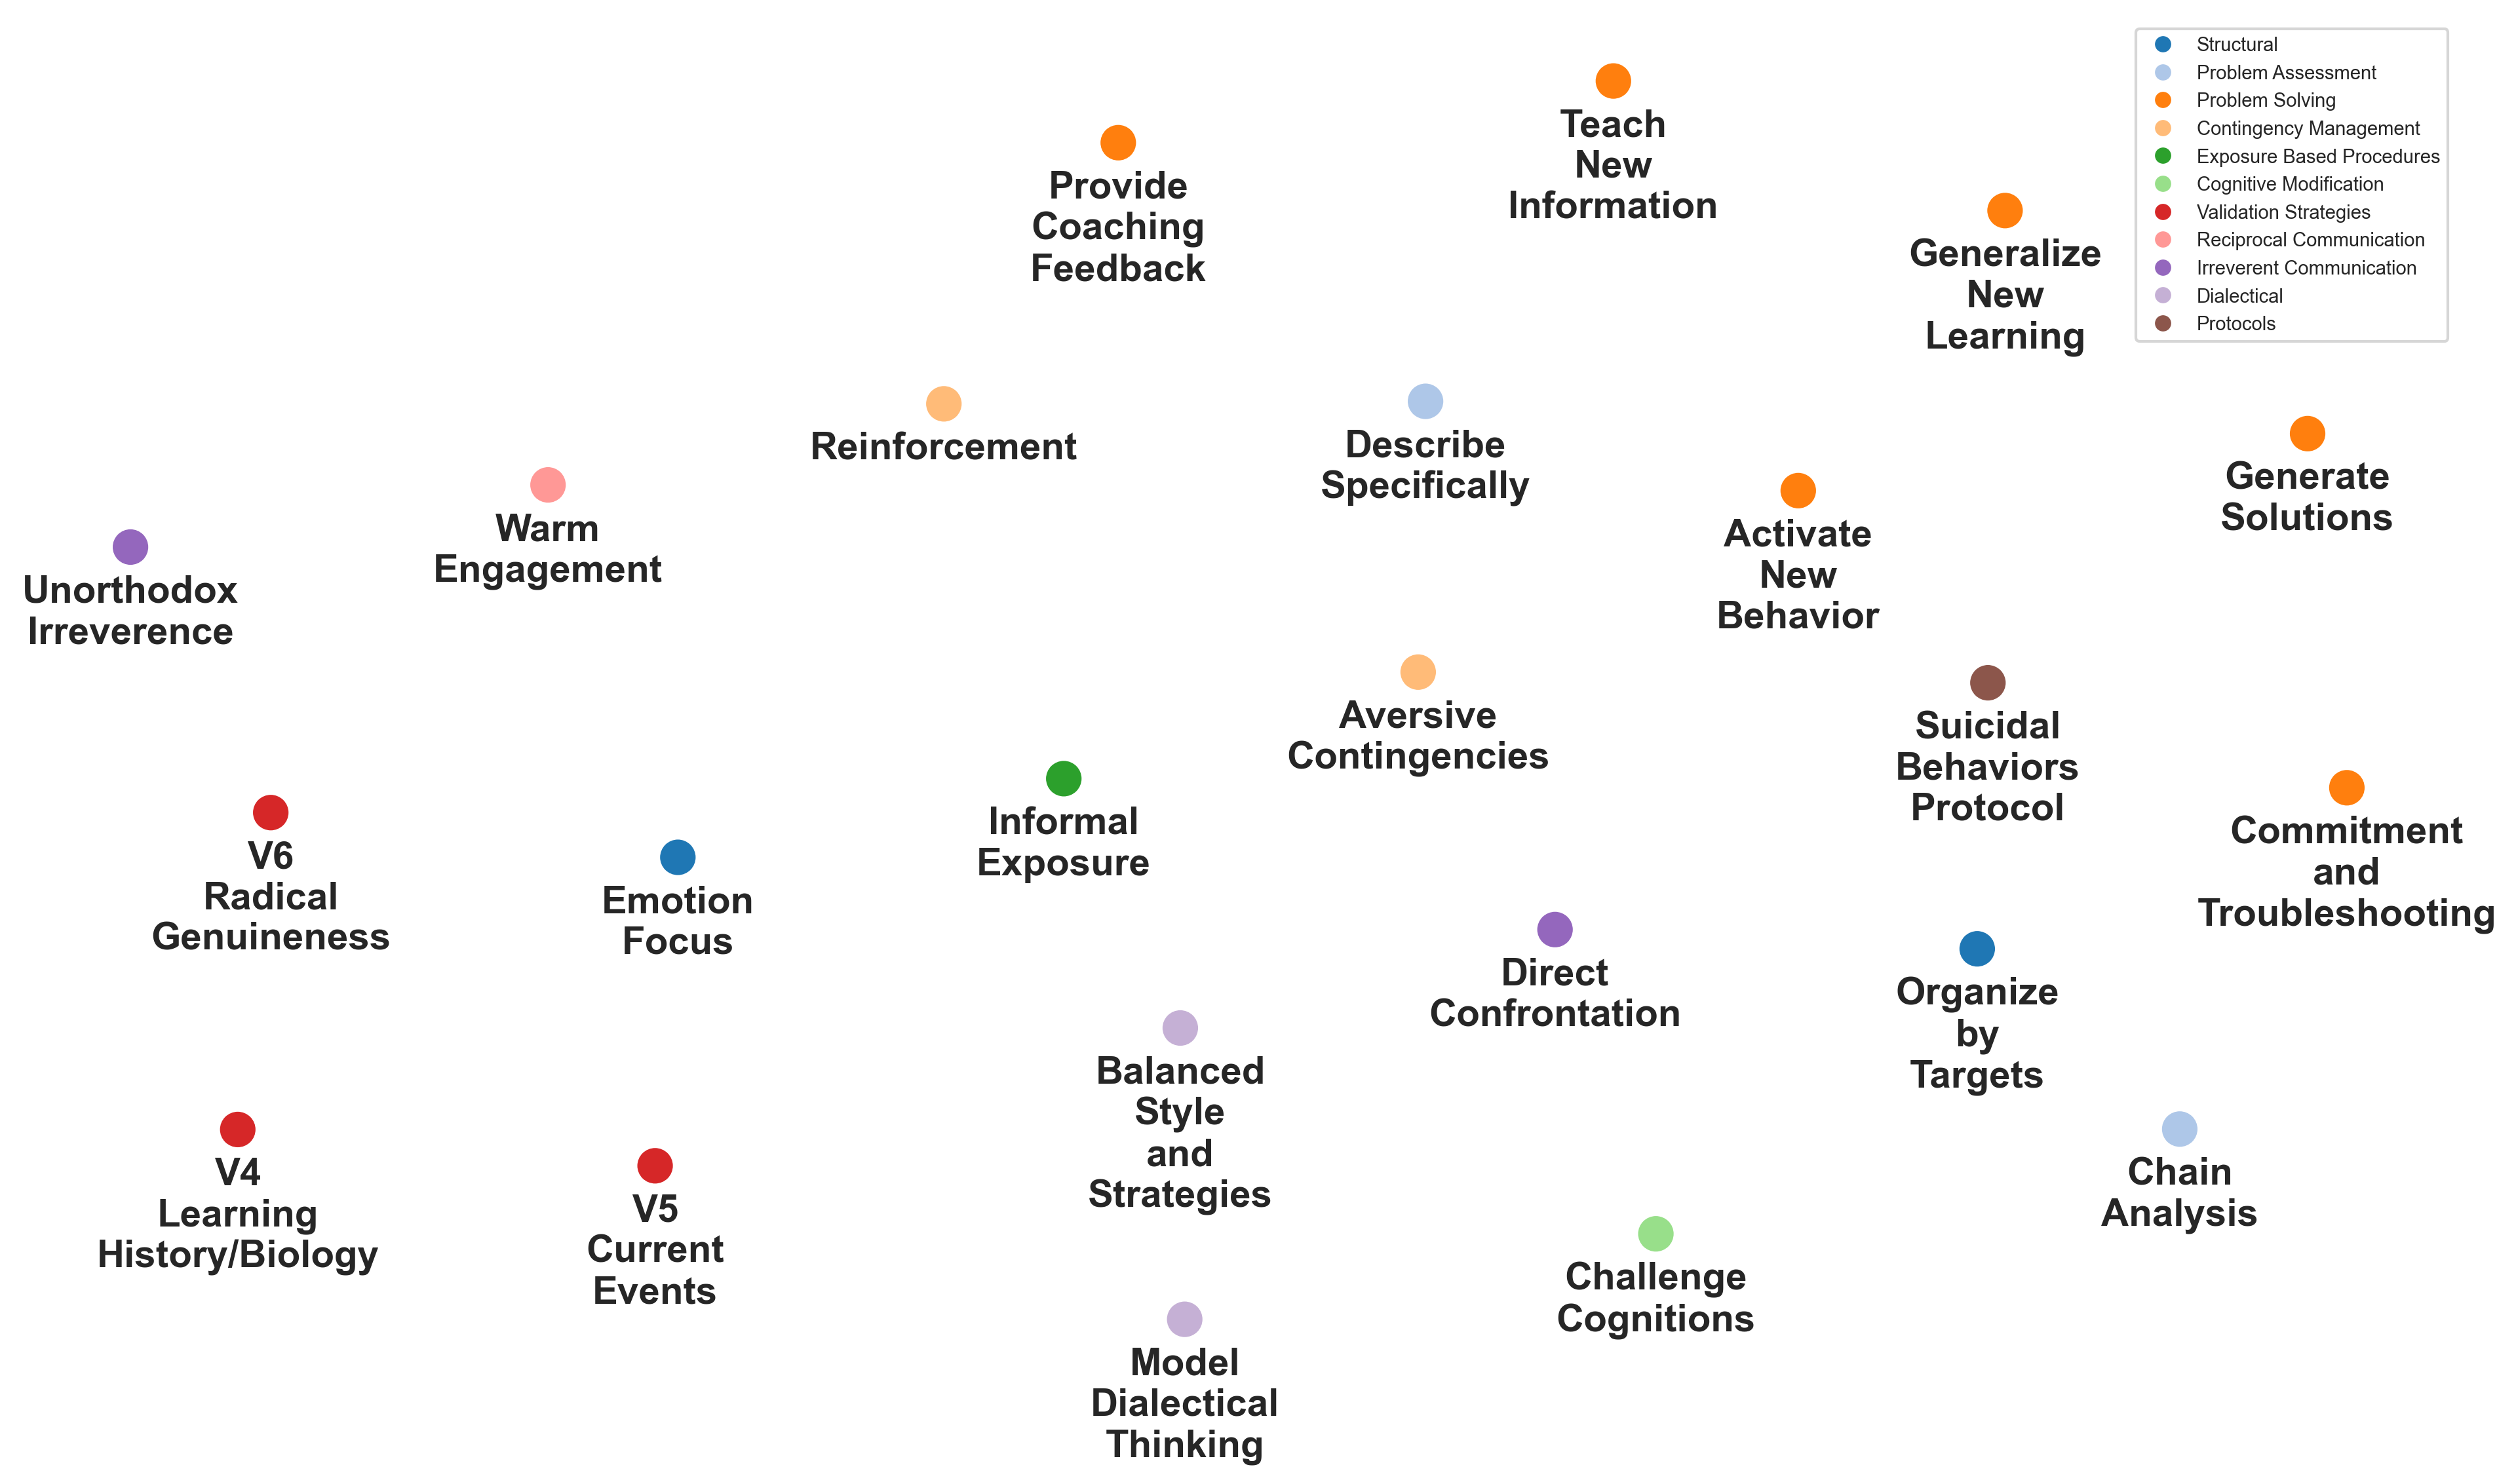

In [565]:
plt.figure(figsize=(16,9), dpi=300)
fig = sns.scatterplot(
    x=adherence_embs_umap[:,0],
    y=adherence_embs_umap[:,1],
    s=200,
    hue=list(adherence_df['Category']),
    palette='tab20'
)
for i in range(len(adherence_df)):
    fig.text(
        x=adherence_embs_umap[i,0],
        y=adherence_embs_umap[i,1]-0.25,
        s='\n'.join(adherence_df['Standard'].iloc[i].split()),
        horizontalalignment='center',
        verticalalignment='top',
        size=14,
        weight='semibold'
    )
# fig.set_aspect('equal')
fig.set_axis_off()
plt.legend(loc='best', markerscale=0.5,fontsize=7)
plt.savefig('adherence_embeddings.png')

In [98]:
with open('./data/dbt_skills_ref.csv') as f:
    skills_df = pd.read_csv(f)
skills_df

,skill_id,skill_name,module_focus,module_name,category_name,skill_desc,use_regex
0,M1,Wise Mind,Acceptance,Mindfulness,Core Mindfulness Skills,"- The ""Wise Mind"" skill in the Mindfulness mod...",True
1,M2,Observe,Acceptance,Mindfulness,"Mindfulness ""What"" Skills","- The ""Observe"" skill in the Mindfulness modul...",True
2,M3,Describe,Acceptance,Mindfulness,"Mindfulness ""What"" Skills","- The ""Describe"" skill in the Mindfulness modu...",True
3,M4,Participate,Acceptance,Mindfulness,"Mindfulness ""What"" Skills","- The ""Participate"" skill in the Mindfulness m...",True
4,M5,Nonjudgmentally,Acceptance,Mindfulness,"Mindfulness ""How"" Skills","- The ""Nonjudgmentally"" skill in the Mindfulne...",True
5,M6,One-Mindfully,Acceptance,Mindfulness,"Mindfulness ""How"" Skills","- The ""One-Mindfully"" skill in the Mindfulness...",True
6,M7,Effectively,Acceptance,Mindfulness,"Mindfulness ""How"" Skills","- The ""Effectively"" skill in the Mindfulness m...",True
7,M8,Mindfulness Practice: A Spiritual Perspective,Acceptance,Mindfulness,Other Perspectives on Mindfulness,"- The ""Mindfulness Practice: A Spiritual Persp...",True
8,M9,Balancing Doing Mind and Being Mind,Acceptance,Mindfulness,Other Perspectives on Mindfulness,"- The ""Balancing Doing Mind and Being Mind"" sk...",True
9,IE1,Clarifying Priorities,Change,Interpersonal Effectiveness,Obtaining Objectives Skillfully,"- The ""Clarifying Priorities"" skill in the Int...",True


In [141]:
skill_embs = np.zeros(shape=(len(skills_df), 1536))
for i, row in skills_df.iterrows():
    txt = row['skill_desc']
    txt_emb = client.embeddings.create(input=txt, model='text-embedding-3-small').data[0].embedding
    skill_embs[i,:] = np.array(txt_emb)
skill_embs

array([[ 0.03279253, -0.0001281 , -0.00014325, ...,  0.01889286,
        -0.01701171,  0.04013137],
       [ 0.01989628,  0.02997548, -0.02494779, ..., -0.01056767,
         0.00835167,  0.04696476],
       [-0.0095403 ,  0.03540143,  0.00239548, ..., -0.00760726,
        -0.01107484,  0.02342252],
       ...,
       [ 0.0142916 ,  0.00269344,  0.05369391, ..., -0.00189982,
        -0.02990481,  0.05447133],
       [ 0.01992044,  0.00089035,  0.04967717, ..., -0.02477336,
        -0.04991199,  0.02109453],
       [ 0.00582257,  0.01049178,  0.05195428, ...,  0.0037714 ,
        -0.03737982,  0.04165255]])

In [165]:
np.sum((skill_embs[5,:] - skill_embs[14,:]) ** 2)

1.027832969889713

In [532]:
umapper = UMAP(
    n_neighbors=12,
    n_components=2,
    min_dist=2.0,
    spread=2.0,
    n_epochs=3000,
    # disconnection_distance=1.5,
    # densmap=True,
)
skill_embs_umap = umapper.fit_transform(skill_embs)
means = np.mean(skill_embs_umap, axis=0)
skill_embs_umap[:,0] -= means[0]
skill_embs_umap[:,1] -= means[1]
skill_embs_umap_ranges = np.ptp(skill_embs_umap, axis=0)
if skill_embs_umap_ranges[0] < skill_embs_umap_ranges[1]:
    skill_embs_umap[:,[0,1]] = skill_embs_umap[:,[1,0]]
skill_embs_umap

C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\umap\umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


array([[ 3.190281  ,  4.00478   ],
       [-0.35980415,  4.900939  ],
       [-0.95234966,  2.1252766 ],
       [ 0.31733608,  7.212701  ],
       [-1.3031349 ,  3.4671164 ],
       [ 1.6588821 ,  6.4772615 ],
       [-4.129431  ,  2.0202637 ],
       [ 1.8108158 ,  4.9214363 ],
       [ 3.5529518 ,  6.548938  ],
       [-6.743486  ,  1.6552277 ],
       [-8.519174  , -0.370327  ],
       [-8.533523  ,  1.7388353 ],
       [-7.78244   ,  3.688774  ],
       [-6.6713142 , -0.19955158],
       [-4.902403  ,  0.22410202],
       [-2.8603382 ,  4.6094284 ],
       [-5.017864  , -1.906177  ],
       [-5.2636695 ,  3.0109053 ],
       [-5.607247  ,  4.738122  ],
       [-6.956856  , -2.6215925 ],
       [-0.81416416, -0.33954334],
       [-2.4035969 , -0.1440134 ],
       [-3.2363195 , -3.6872444 ],
       [-1.8788166 , -2.214933  ],
       [ 0.13825226, -5.9196935 ],
       [-2.2400637 , -5.401644  ],
       [-1.5561132 , -3.8886414 ],
       [ 0.0225687 , -3.9503388 ],
       [ 0.62448597,

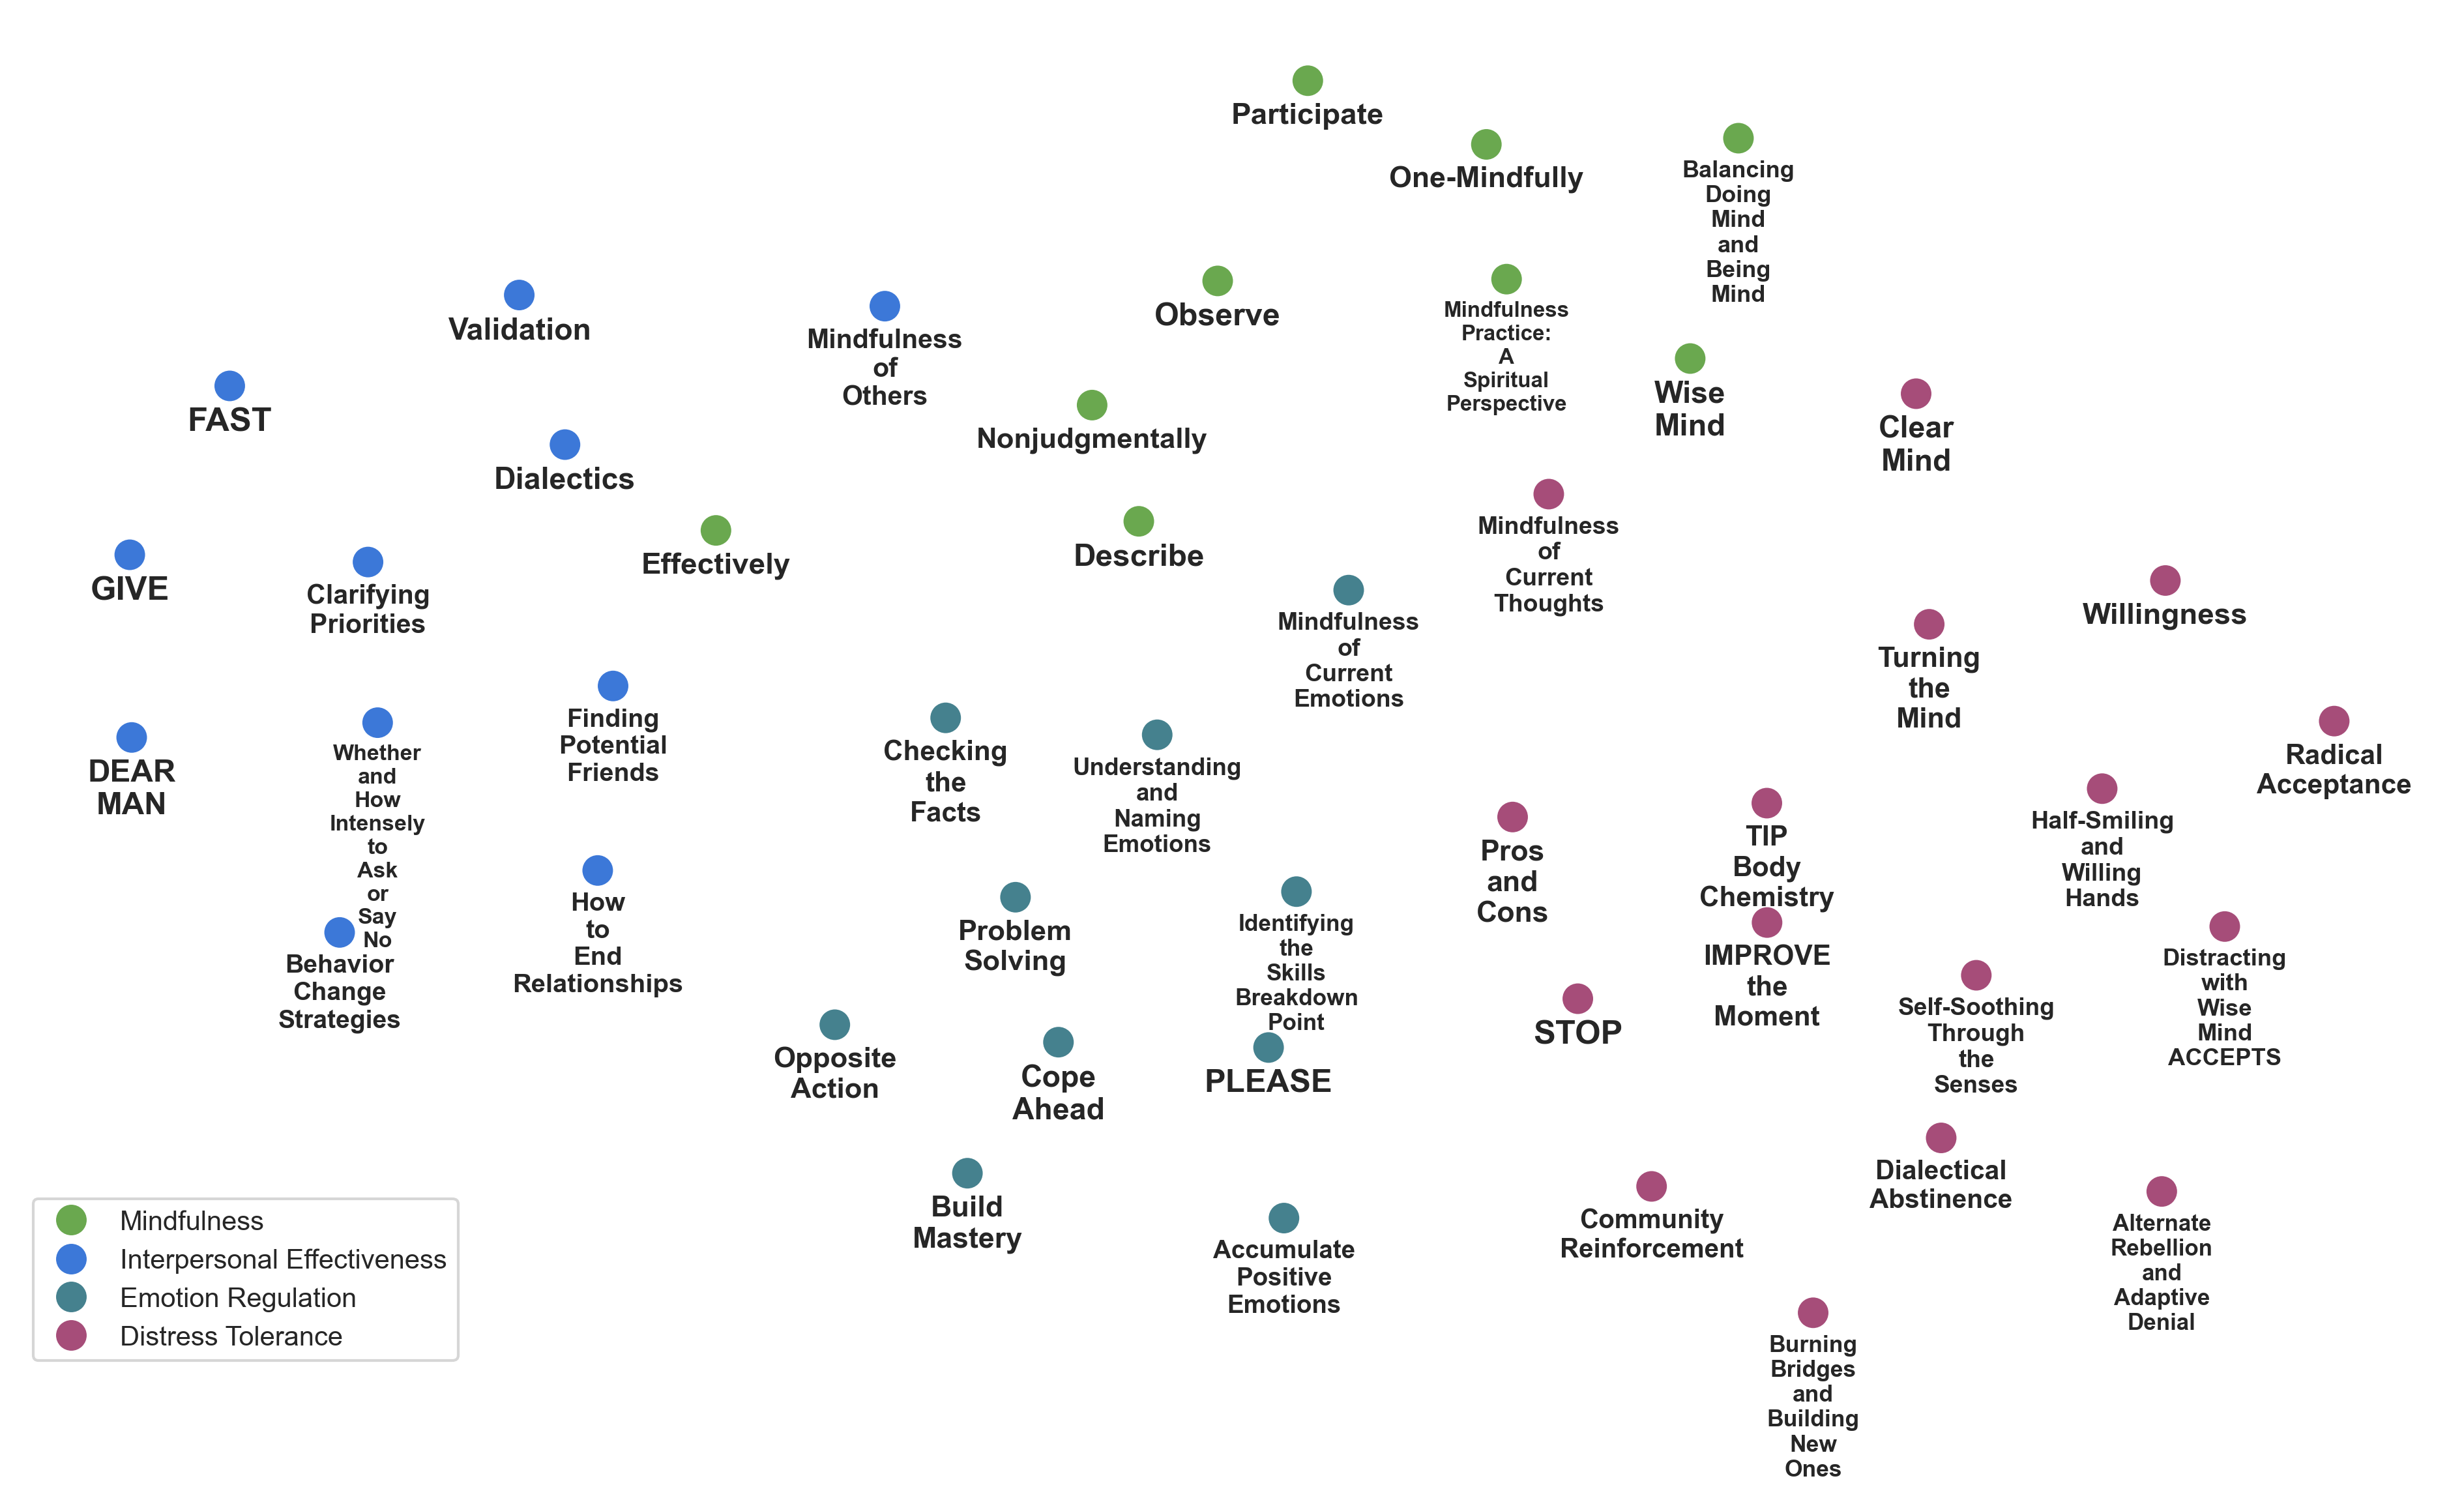

In [548]:
plt.figure(figsize=(16,9), dpi=300)
fig = sns.scatterplot(
    x=skill_embs_umap[:,0],
    y=skill_embs_umap[:,1],
    s=150,
    hue=list(skills_df['module_name']),
    palette={
        'Mindfulness': '#6aa84f',
        'Interpersonal Effectiveness': '#3c78d8',
        'Emotion Regulation': '#45818e',
        'Distress Tolerance': '#a64d79'
    },
)
for i in range(len(skills_df)):
    skill_name = skills_df['skill_name'].iloc[i]
    text_size = 14 - 0.9*(len(skill_name)**0.5)
    fig.text(
        x=skill_embs_umap[i,0],
        y=skill_embs_umap[i,1]-0.25,
        s='\n'.join(skills_df['skill_name'].iloc[i].split()),
        horizontalalignment='center',
        verticalalignment='top',
        size=text_size,
        weight='semibold',
    )
fig.set_axis_off()
# fig.set_aspect('equal')
plt.legend(loc='lower left')
plt.savefig('skill_embeddings.png')

In [175]:
skill_emb_corrs = np.corrcoef(skill_embs)
skill_emb_corrs

array([[1.        , 0.62383851, 0.70463603, ..., 0.53156188, 0.50988441,
        0.47948181],
       [0.62383851, 1.        , 0.71894835, ..., 0.52079709, 0.5093932 ,
        0.48042009],
       [0.70463603, 0.71894835, 1.        , ..., 0.57575363, 0.56455265,
        0.51631459],
       ...,
       [0.53156188, 0.52079709, 0.57575363, ..., 1.        , 0.71823295,
        0.68166152],
       [0.50988441, 0.5093932 , 0.56455265, ..., 0.71823295, 1.        ,
        0.70812012],
       [0.47948181, 0.48042009, 0.51631459, ..., 0.68166152, 0.70812012,
        1.        ]])

<Axes: >

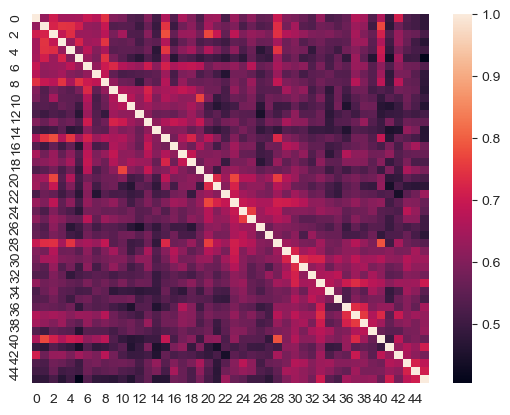

In [176]:
sns.heatmap(skill_emb_corrs)

In [270]:
with open('./data/prompts_with_ids.tsv') as f:
    prompts_df = pd.read_csv(f, delimiter='\t')
prompts_df

,Title,Initial Message,Target Skill IDs,id
0,Solo Wake Planning,My grandmother passed away two days ago and ev...,['M1'],bc97e560-2f17-40c6-bbbc-cf1455e5536b
1,Midnight Mind Marathons,I have a hard time falling asleep at night. I ...,['M2'],817c2b6f-51bf-401c-8b06-cdf9f83b5948
2,Awaking Exhausted,I have been ruminating before falling asleep a...,"['M3', 'ER8']",a26af177-cf8b-41f0-b286-3a1f536544af
3,Distracted Amongst Friends,"Oftentimes when I'm with my friends, I am sitt...",['M4'],4f57e28b-1c11-437c-a067-a725c3b3dd32
4,Tears Trump Talk,Everytime I try to bring up a concern with my ...,['M5'],8ad366a9-643d-4a93-8716-f7df4447d79e
...,...,...,...,...
77,Sick of Sedentary,My partner and I are pretty sedentary. The doc...,['DT15'],1551bb94-6070-498f-a011-9407ed545c45
78,Exam Theft Auto,I was running late for my final so instead of ...,['IE9'],6ac0e128-495a-4244-b60e-642e11cca7ea
79,Reading Pace Pressure,I wanted to pick up the habit of reading. I fo...,['IE10'],711d32a0-4594-498f-9a2b-5f93f2346da7
80,Looming Layoff,There have been rounds of layoffs happening at...,"['ER4', 'DT7']",31ee6726-f6d0-453f-9482-4e36b8dbdc04


In [267]:
summary_sys_prompt = '''
Act as an expert title writer by crafting a very short title for the provided message. In order to best capture the essence of the provided message, <SUMMARY STYLE>.

Instructions:
- Use title case for the title.
- Avoid ending the title with a period or using quotation marks.
- Ensure the title is concise, with only 2, 3, or 4 words.
- Your title should provide a clear indication of the original material's content, pique the reader's interest, and reflect the material's tone.

Example 1:
Input: "I have been trying to take better care of myself, but find it hard to eat healthy because my work meetings often invade my lunch time, so I have to heat up an instant lunch. This doesn't nurture me though and I get a stomachache towards the end of the day."
Response: "Meetings Devour Lunch"

Example 2:
Input: "My girlfriend has been on a work trip for the past three weeks and has constantly missed our calls. She just missed one again and I'm seriously considering breaking up with her."
Response: "Missed-Call Miffed"
'''.strip()

summary_styles = [
    'use a simple, direct approach',
    'use a natural, human-like style',
    'use a creative, unique approach',
    'focus on the most salient details',
    'imagine what it might be like from its author\'s point of view',
    'make use of descriptive language',
    'make use of exaggerated language',
    'make use of subtle, restrained language',
    'make use of humor',
    'make use of alliteration',
    'make use of unusual grammar and/or wording',
]

prompt_summaries = []
# for i, row in prompts_df.iloc[30:35].iterrows():
for i, row in prompts_df.iterrows():
    if i not in [7]:
        continue
    txt = row['Initial Message']
    print(txt, end='\n\n')
    responses = []
    for style in summary_styles:
        response = client2.chat.completions.create(
            messages=[
                {'role': 'system', 'content': summary_sys_prompt.replace('<SUMMARY STYLE>', style)},
                {'role': 'user',   'content': txt},
            ],
            model='gpt4-1106',
            temperature=1.5,
            # top_p=0.0,
        )
        response_txt = response.choices[0].message.content
        print(response_txt)
        responses.append(response_txt)
    print('-'*50)

My wife recently divorced me. She had been been cheating on me and just recently talked to me about it and told me she wasn't happy in our marriage anymore. I had also recently been diagnosed with a form of cancer and now I'm facing that completely alone. It feels as if the world hates me.

Cancer And Betrayal
Adversity Overload
Cancer & Betrayal Storm
Cancer and Betrayal
Wife's Secrets Amid Illness
Betrayal Amidst Illness
Cancern Cheater Crisis
"Solitary Struggle"
Cancer Duel, Wife Defects
Betrayal Amidst Battle
Infidelity Amidst Illness
--------------------------------------------------


In [220]:
prompt_embs = np.zeros(shape=(len(prompts_df), 1536))
for i, row in prompts_df.iterrows():
    txt = row['Initial Message']
    txt_emb = client.embeddings.create(input=txt, model='text-embedding-3-small').data[0].embedding
    prompt_embs[i,:] = np.array(txt_emb)
prompt_embs

array([[ 0.0500899 ,  0.05578605, -0.04599863, ...,  0.00266159,
         0.01341532, -0.01673807],
       [-0.04011571,  0.0170546 , -0.01902059, ...,  0.01327943,
        -0.00548485,  0.00010054],
       [-0.04918456,  0.03810536, -0.0039804 , ..., -0.00846152,
         0.01597231,  0.01459058],
       ...,
       [ 0.00156082, -0.02079398, -0.03565047, ..., -0.02747048,
        -0.03417246,  0.012047  ],
       [-0.00920913, -0.01361183, -0.00409829, ...,  0.01861052,
        -0.03404238, -0.02551897],
       [-0.01644302,  0.00855086, -0.01677237, ...,  0.00583069,
        -0.00547999,  0.01029519]])

In [475]:
umapper = UMAP(
    n_neighbors=35,
    n_components=2,
    min_dist=2.0,
    spread=2.0,
    n_epochs=5000,
    # disconnection_distance=1.2,
    # densmap=True,
    metric='cosine',
)
prompt_embs_umap = umapper.fit_transform(prompt_embs)
means = np.mean(prompt_embs_umap, axis=0)
prompt_embs_umap[:,0] -= means[0]
prompt_embs_umap[:,1] -= means[1]
prompt_embs_umap_ranges = np.ptp(prompt_embs_umap, axis=0)
if prompt_embs_umap_ranges[0] < prompt_embs_umap_ranges[1]:
    prompt_embs_umap[:,[0,1]] = prompt_embs_umap[:,[1,0]]
prompt_embs_umap

C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\umap\umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


array([[ 3.2841835 , -0.26328135],
       [ 4.99395   , -3.643313  ],
       [ 3.1429787 , -5.762109  ],
       [-3.8605194 , -3.3677232 ],
       [ 0.21881485,  2.7189918 ],
       [ 5.827526  , -4.8335996 ],
       [ 3.0784492 , -3.8689277 ],
       [ 1.0545082 ,  1.9480748 ],
       [-1.7920532 , -3.602167  ],
       [ 6.6497574 ,  0.93227196],
       [ 1.3668098 ,  5.494639  ],
       [-4.743393  ,  4.4998183 ],
       [-0.39847183, -4.265648  ],
       [-2.1433105 ,  2.5358815 ],
       [-2.0294685 , -2.4857745 ],
       [-3.6957626 ,  3.3591828 ],
       [ 3.104126  ,  6.824489  ],
       [ 4.163891  ,  1.2026162 ],
       [ 1.159195  , -0.97444916],
       [-4.6324997 ,  2.3121629 ],
       [-0.6449623 , -2.057383  ],
       [ 2.624855  ,  2.3350053 ],
       [-2.988739  , -1.8613763 ],
       [-8.011192  , -2.2397542 ],
       [ 0.52487946, -3.0024338 ],
       [-3.5713387 ,  1.3955007 ],
       [ 1.370697  ,  0.6228018 ],
       [ 1.797245  ,  7.2593427 ],
       [ 0.8788414 ,

In [497]:
gmm = GaussianMixture(
    n_components=12,
    covariance_type='spherical',
    n_init=10,
    max_iter=5000,
).fit_predict(prompt_embs_umap)
gmm

C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\miniconda3\envs\dbt-llm\lib\site-packages\sklearn\cluster\_kmeans.py:1446: User

array([ 3,  8,  0,  7,  1,  8,  9,  1,  7,  3,  1, 11, 10,  1,  5, 11,  6,
        3,  5,  4,  5,  3,  5,  2,  5,  4,  5,  1, 10,  5,  4,  1,  4, 11,
        8,  7,  0,  9,  7,  9,  8,  7,  7,  8,  3,  3,  3, 11,  2,  6,  2,
        4,  1,  1,  6, 11,  6,  1,  4,  7,  8, 10,  3,  6,  1,  1,  6,  8,
        5,  5,  5,  2,  2,  2,  1,  5,  3, 11,  5, 10,  3,  8],
      dtype=int64)

In [494]:
palette = sns.color_palette('husl', n_colors=len(np.unique(gmm)))
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)]

<Axes: >

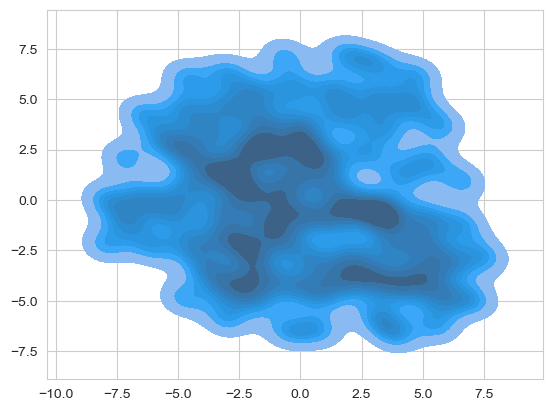

In [495]:
sns.kdeplot(
    x=prompt_embs_umap[:,0],
    y=prompt_embs_umap[:,1],
    bw_adjust=0.4,
    fill=True,
)

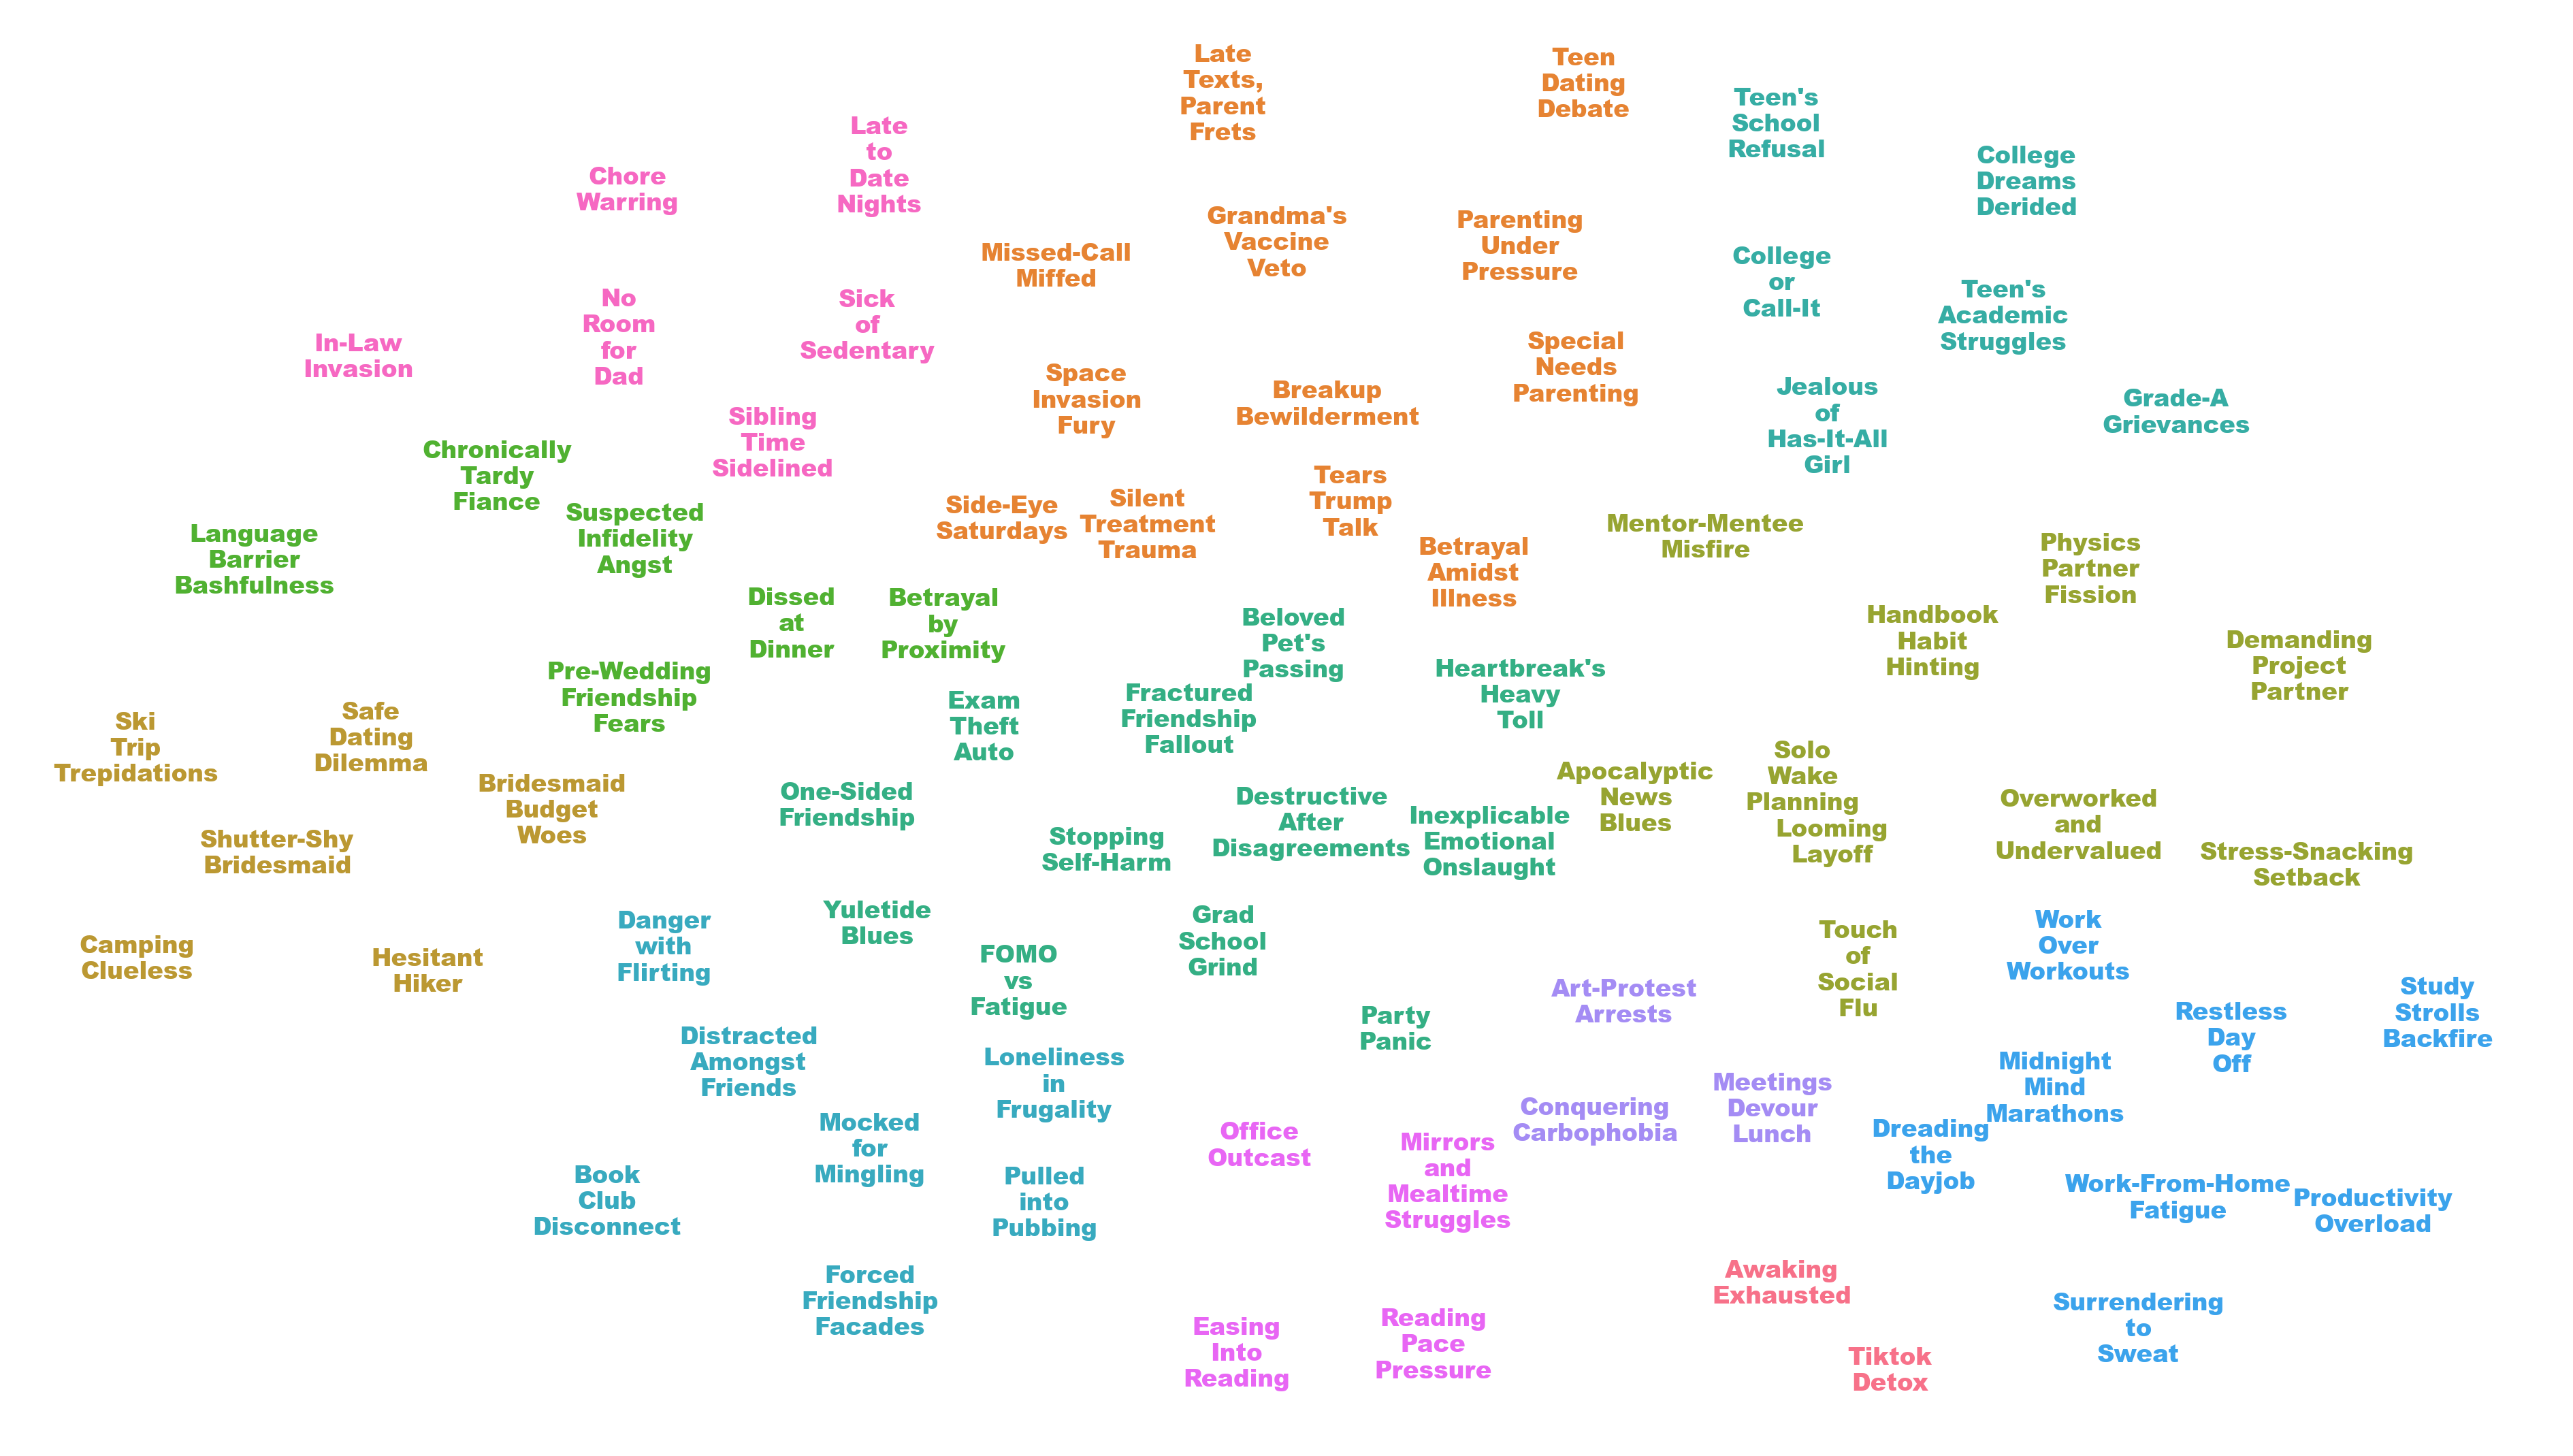

In [513]:
plt.figure(figsize=(16,9), dpi=300)
fig = sns.scatterplot(
    x=prompt_embs_umap[:,0],
    y=prompt_embs_umap[:,1],
    s=0.,
)
cluster_colors = [palette[x] if x >= 0 else (0,0,0) for x in gmm]
for i in range(len(prompts_df)):
    fig.text(
        x=prompt_embs_umap[i,0],
        y=prompt_embs_umap[i,1],
        s='\n'.join(prompts_df['Title'].iloc[i].split()),
        horizontalalignment='center',
        verticalalignment='center',
        size=8.5,
        weight='heavy',
        color=cluster_colors[i],
    )

for direction in ['left', 'right', 'top', 'bottom']:
    fig.spines[direction].set_visible(False)
fig.set_xticks([])
fig.set_yticks([])
# fig.set_aspect('equal')
plt.savefig('prompt_embeddings.png')